# 🤔 Ensemble-based uncertainity qunatification

In this guide, `jax.vmap` is used to create ensemble of `serket` nets. The nets are then trained to model a simple `sin` function with some noise. Eventually, model ensembles stats are plotted to assess the performance of our model.

For more about ensembling [here](http://matpalm.com/blog/ensemble_nets/) is a good read.

In [1]:
!pip install git+https://github.com/ASEM000/serket --quiet

## Imports

In [2]:
import serket as sk
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import functools as ft
import optax

NUM_ENSEMBLES = 20

## Create dummy data

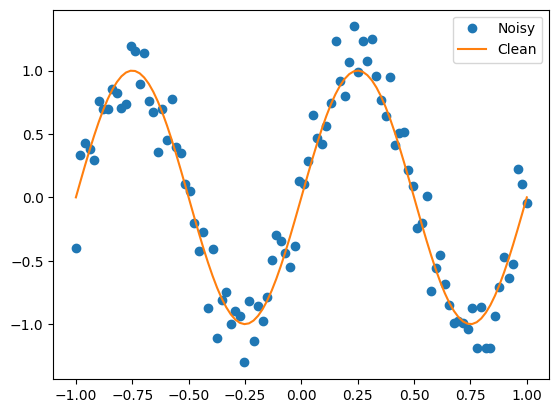

In [3]:
x = jnp.linspace(-1, 1, 100).reshape(-1, 1)  # 100x1
y = jnp.sin(2 * jnp.pi * x) + 0.2 * jr.normal(jr.key(0), (100, 1))  # 100x1
y_clean = jnp.sin(2 * jnp.pi * x)  # 100x1
plt.plot(x, y, "o")
plt.plot(x, y_clean, "-")
plt.legend(["Noisy", "Clean"])
plt.show()

## Create ensemble of `MLP`s

In [4]:
# create identical models with different random initializations
from typing import Generic, TypeVar

T = TypeVar("T")


class Batched(Generic[T]):
    # dummy class to indicate that an object is batched
    # just for demonstration purposes
    ...


def build_ensemble(keys: jax.Array) -> Batched[sk.nn.MLP]:
    def build_single_mlp(key):
        mlp = sk.nn.MLP(
            in_features=1,
            out_features=1,
            hidden_features=20,
            num_hidden_layers=4,
            act="tanh",
            key=key,
        )
        # jax.vmap return must be of jaxtype (i.e. inexact data types)
        # so we use `tree_mask` to hide non-jaxtype attributes (non-trainable parameters)
        return sk.tree_mask(mlp)

    return sk.tree_unmask(jax.vmap(build_single_mlp)(keys))


keys = jr.split(jr.key(0), NUM_ENSEMBLES)
mlps: Batched[sk.nn.MLP] = build_ensemble(keys)

# note that each array in the ensemble has a batch dimension of 10
# that is instead of creating 10 MLPs seperately, we create a single MLP
# with a batch dimension of 10
print(sk.tree_diagram(mlps))

MLP
├── .act=<PjitFunction of <function jax.numpy.tanh at 0x121d68ea0>>
├── .linear_i:Linear
│   ├── .in_features:tuple
│   │   └── [0]=1
│   ├── .out_features=20
│   ├── .weight_init=glorot_uniform
│   ├── .bias_init=zeros
│   ├── .weight=f32[20,1,20](μ=0.00, σ=0.31, ∈[-0.53,0.53])
│   └── .bias=f32[20,20](μ=0.00, σ=0.00, ∈[0.00,0.00])
├── .linear_h:Linear
│   ├── .in_features:tuple
│   │   └── [0]=20
│   ├── .out_features=20
│   ├── .weight_init=glorot_uniform
│   ├── .bias_init=zeros
│   ├── .weight=f32[20,3,20,20](μ=0.00, σ=0.22, ∈[-0.39,0.39])
│   └── .bias=f32[20,3,20](μ=0.00, σ=0.00, ∈[0.00,0.00])
└── .linear_o:Linear
    ├── .in_features:tuple
    │   └── [0]=20
    ├── .out_features=1
    ├── .weight_init=glorot_uniform
    ├── .bias_init=zeros
    ├── .weight=f32[20,20,1](μ=-0.02, σ=0.31, ∈[-0.53,0.53])
    └── .bias=f32[20,1](μ=0.00, σ=0.00, ∈[0.00,0.00])


## Define train setup

In [4]:
def mse(x: jax.Array, y: jax.Array):
    # avoid incorrect broadcasting
    assert x.shape == y.shape
    return jnp.mean((x - y) ** 2)


# vectorize over the ensemble and not on the data (i.e. indicate `None`)
@ft.partial(jax.vmap, in_axes=(0, None, None))
@jax.value_and_grad
def loss_func(mlp: Batched[sk.nn.MLP], x: jax.Array, y: jax.Array):
    # unmask inside the jax boundary
    y_preds = sk.tree_unmask(mlp)(x)
    return mse(y_preds, y)


@jax.jit
def train_step(
    mlps: Batched[sk.nn.MLP],
    optim_state: optax.OptState,
    x: jax.Array,
    y: jax.Array,
):
    # compute the gradients
    loss, grads = loss_func(mlps, x, y)
    updates, optim_state = optim.update(grads, optim_state)
    # apply the gradients
    mlps = optax.apply_updates(mlps, updates)
    return mlps, optim_state, loss


optim = optax.adam(1e-3)
# mask the ensemble outside the jax boundary
mlps = sk.tree_mask(mlps)
optim_state = optim.init(mlps)

# train the ensemble
for i in range(1, 10_000 + 1):
    mlps, optim_state, loss = train_step(mlps, optim_state, x, y)
    if i % 1_000 == 0:
        loss = list(loss)
        loss_string = ", ".join(f"[{i}]={l:.4f}" for i, l in enumerate(loss))
        print(f"epoch:{i}\tloss: {loss_string}")

mlps = sk.tree_unmask(mlps)

epoch:1000	loss: [0]=0.0304, [1]=0.0308, [2]=0.0307, [3]=0.0307, [4]=0.0307, [5]=0.0304, [6]=0.0304, [7]=0.0306, [8]=0.0304, [9]=0.0305, [10]=0.0308, [11]=0.0300, [12]=0.0329, [13]=0.0306, [14]=0.0303, [15]=0.0307, [16]=0.0302, [17]=0.0304, [18]=0.0315, [19]=0.0305
epoch:2000	loss: [0]=0.0298, [1]=0.0301, [2]=0.0305, [3]=0.0286, [4]=0.0282, [5]=0.0300, [6]=0.0299, [7]=0.0303, [8]=0.0297, [9]=0.0302, [10]=0.0302, [11]=0.0284, [12]=0.0308, [13]=0.0301, [14]=0.0296, [15]=0.0303, [16]=0.0290, [17]=0.0298, [18]=0.0308, [19]=0.0301
epoch:3000	loss: [0]=0.0292, [1]=0.0293, [2]=0.0313, [3]=0.0263, [4]=0.0265, [5]=0.0294, [6]=0.0261, [7]=0.0297, [8]=0.0287, [9]=0.0280, [10]=0.0298, [11]=0.0264, [12]=0.0310, [13]=0.0299, [14]=0.0281, [15]=0.0299, [16]=0.0248, [17]=0.0294, [18]=0.0307, [19]=0.0293
epoch:4000	loss: [0]=0.0267, [1]=0.0278, [2]=0.0297, [3]=0.0255, [4]=0.0255, [5]=0.0277, [6]=0.0228, [7]=0.0280, [8]=0.0274, [9]=0.0243, [10]=0.0291, [11]=0.0255, [12]=0.0306, [13]=0.0288, [14]=0.0260, 

## Plot results

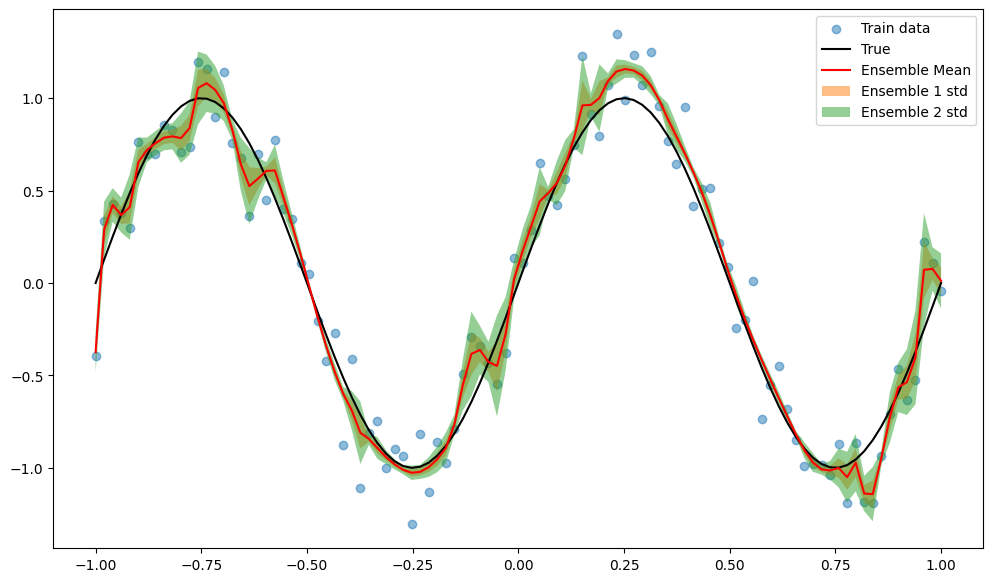

In [5]:
def run_single_input_ensemble(mlps: Batched[sk.nn.MLP], x: jax.Array):
    # mask/unmask acroos the jax boundary (i.e. vmap here)
    return jax.vmap(lambda mlp: sk.tree_unmask(mlp)(x))(sk.tree_mask(mlps))


ypreds = run_single_input_ensemble(mlps, x)
ypreds_mean = jnp.mean(ypreds, axis=0)
ypreds_std = jnp.std(ypreds, axis=0)

plt.figure(figsize=(12, 7))

plt.scatter(x, y, label="Train data", alpha=0.5)
plt.plot(x, y_clean, "-k", label="True")
plt.plot(x, ypreds_mean, "-r", label="Ensemble Mean")
plt.fill_between(
    x.ravel(),
    (ypreds_mean - ypreds_std).ravel(),
    (ypreds_mean + ypreds_std).ravel(),
    alpha=0.5,
    label="Ensemble 1 std",
)

plt.fill_between(
    x.ravel(),
    (ypreds_mean - 2 * ypreds_std).ravel(),
    (ypreds_mean + 2 * ypreds_std).ravel(),
    alpha=0.5,
    label="Ensemble 2 std",
)

plt.legend()